In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
projectPath = '/content/drive/MyDrive/GT/Academics-GT/DL/FinalProject'
# projectPath = '/content/drive/MyDrive/College/S6/CS7643/FinalProject'
# projectPath = '/content/drive/MyDrive/FinalProject'

import sys
sys.path.append(projectPath)

In [ ]:
!pip install pytorch-lightning

     |████████████████████████████████| 563kB 5.9MB/s 
     |████████████████████████████████| 92kB 9.4MB/s 
     |████████████████████████████████| 276kB 38.5MB/s 
     |████████████████████████████████| 829kB 29.3MB/s 
  Created wheel for PyYAML: filename=PyYAML-5.3.1-cp36-cp36m-linux_x86_64.whl size=44619 sha256=b421b36bae3bbb3b5a06f8dcf638fcc11cad998c25b5fc81468d0e09e2bc56c0
  Stored in directory: /root/.cache/pip/wheels/a7/c1/ea/cf5bd31012e735dc1dfea3131a2d5eae7978b251083d6247bd
  Created wheel for future: filename=future-0.18.2-cp36-none-any.whl size=491057 sha256=55b7f4b5ad3b1864857a9b81b828275af34ef05f6428f9daa7c5dd156b07cccc
  Stored in directory: /root/.cache/pip/wheels/8b/99/a0/81daf51dcd359a9377b110a8a886b3895921802d2fc1b2397e
Successfully built PyYAML future
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Found existing installation: future 0.16.0
    Uninstalling future-0.16.0:
      Successfully uninst

In [ ]:
!pip install l5kit
!pip install -U PyYAML

     |████████████████████████████████| 92kB 4.0MB/s 
     |████████████████████████████████| 42.9MB 103kB/s 
     |████████████████████████████████| 71kB 8.7MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 133kB 53.6MB/s 
     |████████████████████████████████| 5.8MB 45.2MB/s 
  Created wheel for pymap3d: filename=pymap3d-2.4.3-cp36-none-any.whl size=33551 sha256=cf8beb77e8072d1ddb2bca115f3af6b9400ce1b76105611eec2eb6e1644f2dd3
  Stored in directory: /root/.cache/pip/wheels/be/e2/40/c642184272827b886ddb12661008199fe1460d4b05ddfc2670
Successfully built pymap3d
  Created wheel for ptable: filename=PTable-0.9.2-cp36-none-any.whl size=22905 sha256=02c30f1bcf96bbd22a1297959a6dcc1cc60865e255c3ef93f6174717d378076d
  Stored in directory: /root/.cache/pip/wheels/22/cc/2e/55980bfe86393df3e9896146a01f6802978d09d7ebcba5ea56
  Created wheel for transforms3d: filename=transforms

In [ ]:
!mkdir /root/.kaggle/
!touch /root/.kaggle/kaggle.json
!echo '{"username":"simarkareer","key":"ff816530aeb5eda4d7ce160a471cbe14"}' >> /root/.kaggle/kaggle.json
!cat /root/.kaggle/kaggle.json
!mkdir lyftdataset
!cd lyftdataset
!pip install --upgrade --force-reinstall --no-deps kaggle
!kaggle --version
!kaggle competitions download -c lyft-motion-prediction-autonomous-vehicles -p /content/lyftdataset/

{"username":"simarkareer","key":"ff816530aeb5eda4d7ce160a471cbe14"}
     |████████████████████████████████| 61kB 3.3MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.10-cp36-none-any.whl size=73269 sha256=daf2cdeb9072cf4d2cf473b611a0a09e0908ac7cc3f5eed90123149bff342256
  Stored in directory: /root/.cache/pip/wheels/3a/d1/7e/6ce09b72b770149802c653a02783821629146983ee5a360f10
Successfully built kaggle
  Found existing installation: kaggle 1.5.9
    Uninstalling kaggle-1.5.9:
      Successfully uninstalled kaggle-1.5.9
Kaggle API 1.5.10
100% 18.3G/18.3G [05:02<00:00, 141MB/s]
100% 18.3G/18.3G [05:02<00:00, 64.7MB/s]


In [ ]:
from utils import *
from mhajam import *
from MultiAgentLoaders import *

In [ ]:
%cd lyftdataset
!unzip -q lyft-motion-prediction-autonomous-vehicles.zip

/content/lyftdataset


In [ ]:
# Make sure you are in /content/lyftdataset
!pwd
# %cd lyftdataset

/content/lyftdataset


In [ ]:
from typing import Dict

from tempfile import gettempdir
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision.models.resnet import resnet50
from tqdm import tqdm

from l5kit.configs import load_config_data
from l5kit.data import LocalDataManager, ChunkedDataset
from l5kit.dataset import AgentDataset, EgoDataset
from l5kit.rasterization import build_rasterizer
from l5kit.evaluation import write_pred_csv, compute_metrics_csv, read_gt_csv, create_chopped_dataset
from l5kit.evaluation.chop_dataset import MIN_FUTURE_STEPS
from l5kit.evaluation.metrics import neg_multi_log_likelihood, time_displace
from l5kit.geometry import transform_points
from l5kit.visualization import PREDICTED_POINTS_COLOR, TARGET_POINTS_COLOR, draw_trajectory
from prettytable import PrettyTable
from pathlib import Path

import os

## Prepare Data path and load cfg

By setting the `L5KIT_DATA_FOLDER` variable, we can point the script to the folder where the data lies.

Then, we load our config file with relative paths and other configurations (rasteriser, training params...).

In [ ]:
# set env variable for data
os.environ["L5KIT_DATA_FOLDER"] = "/content/lyftdataset"
dm = LocalDataManager(None)
# get config
cfg = load_config_data(projectPath + "/agent_motion_config.yaml")
print(cfg)

{'format_version': 4, 'model_params': {'model_architecture': 'resnet50', 'input_size': 3, 'input_embedding_size': 32, 'encoder_size': 64, 'decoder_size': 128, 'num_heads': 16, 'prob_fc1_out': 100, 'rasterCNN_conv1_kernel_size': 7, 'rasterCNN_conv1_stride': 2, 'rasterCNN_conv1_padding': 0, 'history_num_frames': 60, 'history_step_size': 1, 'history_delta_time': 0.1, 'future_num_frames': 50, 'future_step_size': 1, 'future_delta_time': 0.1, 'cnn_out_channels': 64, 'q_out_channels': 64, 'raster_img_center_offset': 112}, 'raster_params': {'raster_size': [224, 224], 'pixel_size': [0.5, 0.5], 'ego_center': [0.5, 0.5], 'map_type': 'py_semantic', 'satellite_map_key': 'aerial_map/aerial_map.png', 'semantic_map_key': 'semantic_map/semantic_map.pb', 'dataset_meta_key': 'meta.json', 'filter_agents_threshold': 0.5, 'disable_traffic_light_faces': False}, 'train_dataloader': {'key': 'scenes/sample.zarr', 'batch_size': 10, 'shuffle': True, 'num_workers': 16}, 'val_dataloader': {'key': 'scenes/sample.zar

## Model

Our baseline is a simple `resnet50` pretrained on `imagenet`. We must replace the input and the final layer to address our requirements.

In [ ]:
def build_model(cfg: Dict) -> torch.nn.Module:
    # load pre-trained Conv2D model
    model = resnet50(pretrained=True)

    # change input channels number to match the rasterizer's output
    num_history_channels = (cfg["model_params"]["history_num_frames"] + 1) * 2
    num_in_channels = 3 + num_history_channels
    model.conv1 = nn.Conv2d(
        num_in_channels,
        model.conv1.out_channels,
        kernel_size=model.conv1.kernel_size,
        stride=model.conv1.stride,
        padding=model.conv1.padding,
        bias=False,
    )
    # change output size to (X, Y) * number of future states
    num_targets = 2 * cfg["model_params"]["future_num_frames"]
    model.fc = nn.Linear(in_features=2048, out_features=num_targets)

    return model

In [ ]:
def forward(data, model, device, criterion):
    inputs = data["image"].to(device)
    target_availabilities = data["target_availabilities"].unsqueeze(-1).to(device)
    targets = data["target_positions"].to(device)
    # Forward pass
    outputs = model(inputs).reshape(targets.shape)
    loss = criterion(outputs, targets)
    # not all the output steps are valid, but we can filter them out from the loss using availabilities
    loss = loss * target_availabilities
    loss = loss.mean()
    return loss, outputs

## Load the Train Data

Our data pipeline map a raw `.zarr` folder into a multi-processing instance ready for training by:
- loading the `zarr` into a `ChunkedDataset` object. This object has a reference to the different arrays into the zarr (e.g. agents and traffic lights);
- wrapping the `ChunkedDataset` into an `AgentDataset`, which inherits from torch `Dataset` class;
- passing the `AgentDataset` into a torch `DataLoader`

In [ ]:
projectPath = '/content/drive/MyDrive/GT/Academics-GT/DL/FinalProject'
# projectPath = '/content/drive/MyDrive/College/S6/CS7643/FinalProject'
# projectPath = '/content/drive/MyDrive/FinalProject'

import sys
sys.path.append(projectPath)

from utils import *
from MultiAgentLoaders import *
from mhajam import *

!pwd
%cd lyftdataset

from typing import Dict

from tempfile import gettempdir
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision.models.resnet import resnet50
from tqdm import tqdm

from l5kit.configs import load_config_data
from l5kit.data import LocalDataManager, ChunkedDataset
from l5kit.dataset import AgentDataset, EgoDataset
from l5kit.rasterization import build_rasterizer
from l5kit.evaluation import write_pred_csv, compute_metrics_csv, read_gt_csv, create_chopped_dataset
from l5kit.evaluation.chop_dataset import MIN_FUTURE_STEPS
from l5kit.evaluation.metrics import neg_multi_log_likelihood, time_displace
from l5kit.geometry import transform_points
from l5kit.visualization import PREDICTED_POINTS_COLOR, TARGET_POINTS_COLOR, draw_trajectory
from prettytable import PrettyTable
from pathlib import Path

import os

# set env variable for data
os.environ["L5KIT_DATA_FOLDER"] = "/content/lyftdataset"
dm = LocalDataManager(None)
# get config
cfg = load_config_data(projectPath + "/agent_motion_config.yaml")
print(cfg)

/content/lyftdataset
[Errno 2] No such file or directory: 'lyftdataset'
/content/lyftdataset
{'format_version': 4, 'model_params': {'model_architecture': 'resnet50', 'input_size': 3, 'input_embedding_size': 32, 'encoder_size': 64, 'decoder_size': 128, 'num_heads': 16, 'prob_fc1_out': 100, 'rasterCNN_conv1_kernel_size': 7, 'rasterCNN_conv1_stride': 2, 'rasterCNN_conv1_padding': 0, 'history_num_frames': 60, 'history_step_size': 1, 'history_delta_time': 0.1, 'future_num_frames': 50, 'future_step_size': 1, 'future_delta_time': 0.1, 'cnn_out_channels': 64, 'q_out_channels': 64, 'raster_img_center_offset': 112}, 'raster_params': {'raster_size': [224, 224], 'pixel_size': [0.5, 0.5], 'ego_center': [0.5, 0.5], 'map_type': 'py_semantic', 'satellite_map_key': 'aerial_map/aerial_map.png', 'semantic_map_key': 'semantic_map/semantic_map.pb', 'dataset_meta_key': 'meta.json', 'filter_agents_threshold': 0.5, 'disable_traffic_light_faces': False}, 'train_dataloader': {'key': 'scenes/sample.zarr', 'batch

In [ ]:
datamodule = MultiAgentDataModule(cfg)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [ ]:
# mhajam = MHAJAM(cfg['model_params'])

In [ ]:
# for item in datamodule.train_dataloader():
#     # print(item['ego_dict'].keys())
#     # print(item['ego_dict']['history_positions'].shape, len(item['others_dict']))
#     # print(item['others_dict'][0].keys())
#     (agentsHist, lengths, rastImg, targetPos, targetValid, agent_from_raster) = item
#     print(agentsHist.shape, lengths, rastImg.shape, targetPos.shape, targetValid.shape, agent_from_raster.shape)
#     # print(agentsHist.type(), lengths, rastImg.type(), targetPos.type(), targetValid.type())
#     # print(agentsHist[0][0])
#     # print(targetPos)
#     # print(targetValid)
#     result = mhajam(item)
#     # print('result', result[0])
#     # print('target', targetPos[0])
#     break

In [ ]:
# ===== INIT DATASET
train_cfg = cfg["train_dataloader"]
rasterizer = build_rasterizer(cfg, dm)
train_zarr = ChunkedDataset(dm.require(train_cfg["key"])).open()
train_dataset = AgentDataset(cfg, train_zarr, rasterizer)
train_dataloader = DataLoader(train_dataset, shuffle=train_cfg["shuffle"], batch_size=train_cfg["batch_size"], 
                             num_workers=train_cfg["num_workers"])


In [ ]:
# for item in train_dataloader:
#     print(item.keys())
#     break

In [ ]:
mhajam = MHAJAM(cfg['model_params'])

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


In [ ]:
# ==== INIT MODEL
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# model = build_model(cfg).to(device)
optimizer = optim.Adam(mhajam.parameters(), lr=6e-3)
criterion = nn.MSELoss(reduction="none")

NameError: ignored

In [ ]:
# LOSS
def custom_neg_multi_log_likelihood(
    ground_truth: np.ndarray, pred: np.ndarray, confidences: np.ndarray, avails: np.ndarray
) -> np.ndarray:
    """
    Compute a negative log-likelihood for the multi-modal scenario.
    log-sum-exp trick is used here to avoid underflow and overflow, For more information about it see:
    https://en.wikipedia.org/wiki/LogSumExp#log-sum-exp_trick_for_log-domain_calculations
    https://timvieira.github.io/blog/post/2014/02/11/exp-normalize-trick/
    https://leimao.github.io/blog/LogSumExp/
    For more details about used loss function and reformulation, please see
    https://github.com/lyft/l5kit/blob/master/competition.md.
    Args:
        ground_truth (np.ndarray): array of shape (B, T, 2)
        pred (np.ndarray): array of shape (B, numHeads, T, 2)
        confidences (np.ndarray): (B, numHeads)
        avails (np.ndarray): (B, T)
    Returns:
        np.ndarray: negative log-likelihood for this example, a single float number
    """
    # _assert_shapes(ground_truth, pred, confidences, avails)
    # ground_truth = np.expand_dims(ground_truth, 0)  # add modes
    ground_truth = ground_truth.unsqueeze(1)
    # avails = avails[np.newaxis, :, np.newaxis]  # add modes and cords
    avails = avails.unsqueeze(1).unsqueeze(-1)

    error = torch.sum(((ground_truth - pred) * avails) ** 2, dim=-1)  # reduce coords and use availability
    # (B, numHeads, T)

    # with np.errstate(divide="ignore"):  # when confidence is 0 log goes to -inf, but we're fine with it
    confidences = confidences + 1e-15
    error = torch.log(confidences) - 0.5 * torch.sum(error, dim=-1)  # reduce timesteps
    # (B, numHeads)

    # use max aggregator on modes for numerical stability
    max_value = error.max() # error are negative at this point, so max() gives the minimum one
    # error = -torch.log(torch.sum(torch.exp(error - max_value), dim=-1)) - max_value  # reduce modes
    error = -torch.logsumexp(error - max_value, keepdim=True, dim=-1) - max_value
    return error.mean()

In [ ]:
# ==== TRAIN LOOP

for epoch in range(2):
    tr_it = iter(datamodule.train_dataloader())
    progress_bar = tqdm(range(len(datamodule.train_dataloader())))
    losses_train = []
    mhajam = mhajam.to(device)
    for _ in progress_bar:
        try:
            data = next(tr_it)
        except StopIteration:
            tr_it = iter(train_dataloader)
            data = next(tr_it)

        mhajam.train()
        torch.set_grad_enabled(True)
        torch.autograd.set_detect_anomaly(True)
        
        agentsHist, lengths, rastImg, targetPos, targetValid, agentFromRaster = data
        agentsHist = agentsHist.to(device)
        rastImg = rastImg.to(device)
        targetPos = targetPos.to(device)
        targetValid = targetValid.to(device)
        agentFromRaster = agentFromRaster.to(device)
        
        # Forward pass
        aggregatedPredictions, probability, _ = mhajam((agentsHist, lengths, rastImg, targetPos, targetValid, agentFromRaster))

        # loss = criterion(outputs, targets)
        # not all the output steps are valid, but we can filter them out from the loss using availabilities
        # loss = loss * target_availabilities
        # loss = loss.mean()
        loss = custom_neg_multi_log_likelihood(targetPos, aggregatedPredictions, probability, targetValid)
        # loss = torch.sum(aggregatedPredictions)
        # loss, _ = forward(data, model, device, criterion)

        # print("\nepoch: ", epoch, "\nloss: ", loss.item())

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses_train.append(loss.item())
        progress_bar.set_description(f"loss: {loss.item()} loss(avg): {np.mean(losses_train)}")
    if epoch == 0:
        torch.save(mhajam.state_dict(), '/content/drive/MyDrive/College/S6/CS7643/FinalProject/mhajamEpoch1H90.pth')

loss: 39.12910842895508 loss(avg): 3790.2288248488244:   0%|          | 47/11164 [05:25<16:19:31,  5.29s/it]

In [70]:
# cfg['model_params']['history_num_frames'] = 60
datamodule = MultiAgentDataModule(cfg)
mhajam = MHAJAM(cfg['model_params'])
mhajam.load_state_dict(torch.load(projectPath + "/mhajamOutputToInput2400H900.pt", map_location=torch.device(device)))
# mhajam.load_state_dict(torch.load(projectPath + "/mhajamEpoch1.pth"))
mhajam.eval()

MHAJAM(
  (lstmEnc): LSTM(32, 64, batch_first=True)
  (rasterCNN): Sequential(
    (0): Conv2d(125, 64, kernel_size=(7, 7), stride=(2, 2), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequent


































































  0%|          | 0/11164 [00:00<?, ?it/s]

torch.Size([3, 3]) torch.Size([10, 16, 50, 2])
agg targets shape:  (10, 50, 2)
[array([0.5, 0. , 1. , 1. ]), array([0.5, 0. , 1. , 1. ]), array([0.5, 0. , 1. , 1. ]), array([0.5, 0. , 1. , 1. ]), array([0.5, 0. , 1. , 1. ]), array([0.5, 0. , 1. , 1. ]), array([0.5, 0. , 1. , 1. ]), array([0.5, 0. , 1. , 1. ]), array([0.5, 0. , 1. , 1. ]), array([0.5, 0. , 1. , 1. ]), array([0.5, 0. , 1. , 1. ]), array([0.5, 0. , 1. , 1. ]), array([0.5, 0. , 1. , 1. ]), array([0.5, 0. , 1. , 1. ]), array([0.5, 0. , 1. , 1. ]), array([0.5, 0. , 1. , 1. ]), array([0.5, 0. , 1. , 1. ]), array([0.5, 0. , 1. , 1. ]), array([0.5, 0. , 1. , 1. ]), array([0.5, 0. , 1. , 1. ]), array([0.5, 0. , 1. , 1. ]), array([0.5, 0. , 1. , 1. ]), array([0.5, 0. , 1. , 1. ]), array([0.5, 0. , 1. , 1. ]), array([0.5, 0. , 1. , 1. ]), array([0.5, 0. , 1. , 1. ]), array([0.5, 0. , 1. , 1. ]), array([0.5, 0. , 1. , 1. ]), array([0.5, 0. , 1. , 1. ]), array([0.5, 0. , 1. , 1. ]), array([0.5, 0. , 1. , 1. ]), array([0.5, 0. , 1. ,

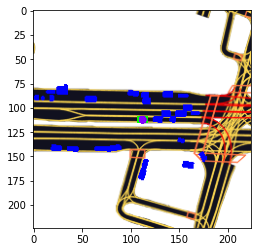

Head number 0


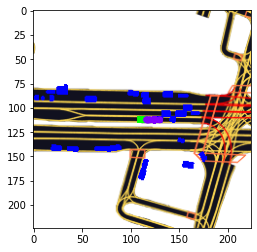

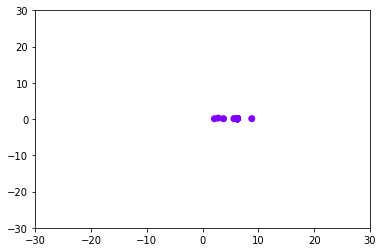

Head number 1


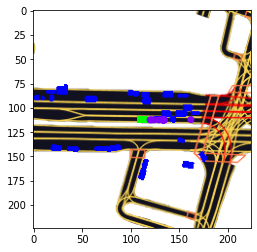

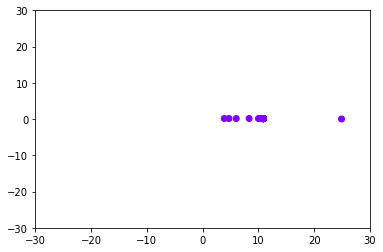

Head number 2


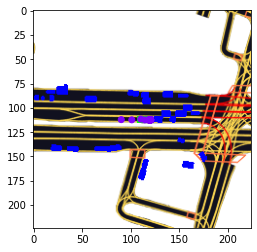

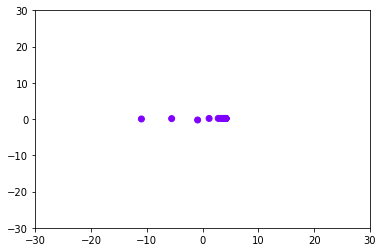

Head number 3


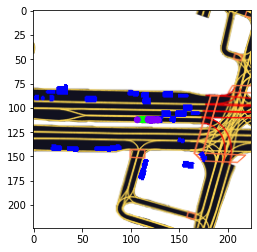

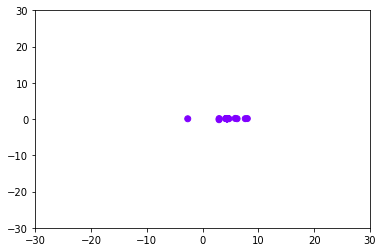

Head number 4


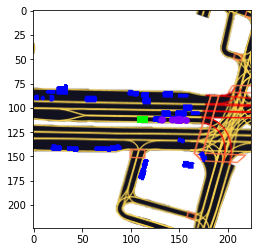

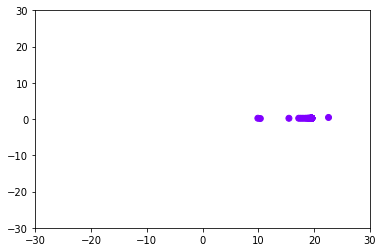

Head number 5


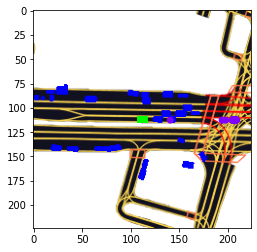

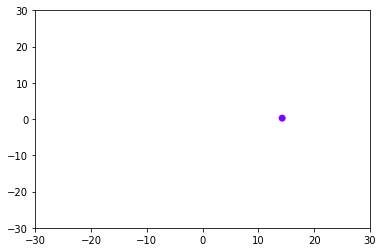

Head number 6


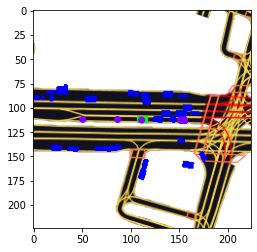

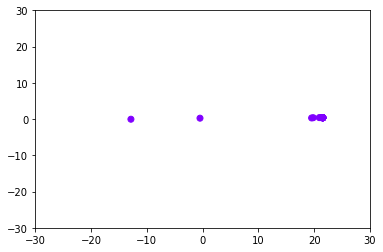

Head number 7


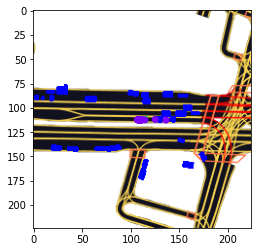

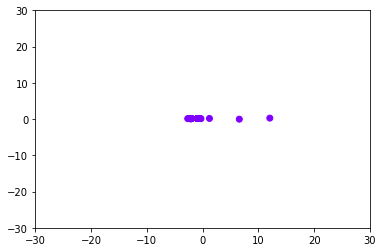

Head number 8


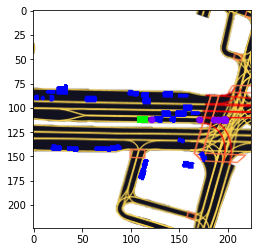

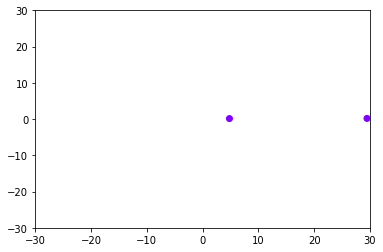

Head number 9


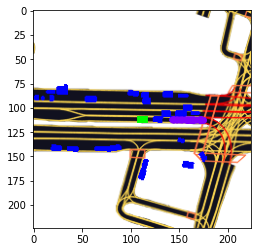

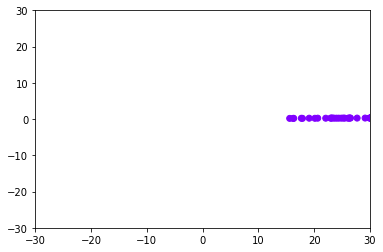

Head number 10


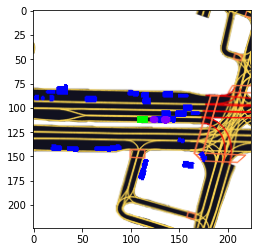

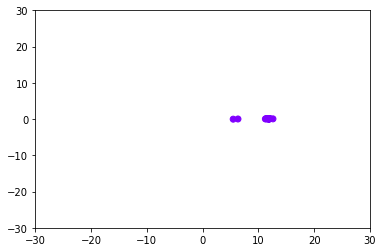

Head number 11


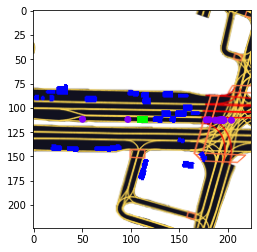

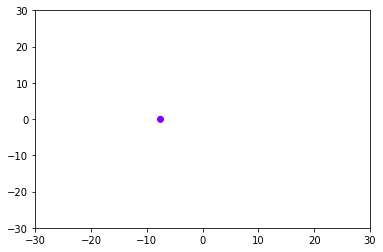

Head number 12


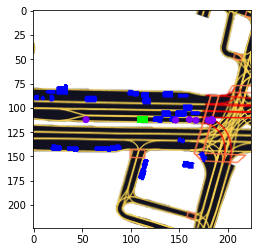

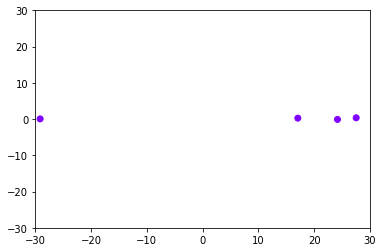

Head number 13


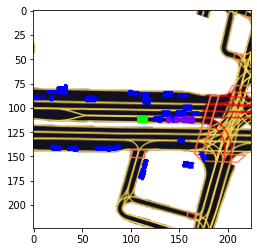

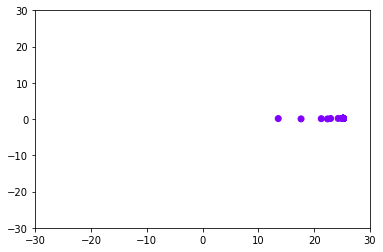

Head number 14


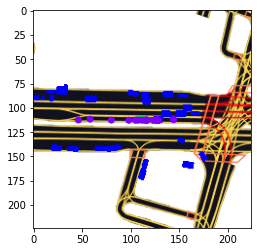

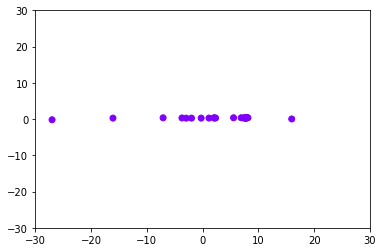

Head number 15


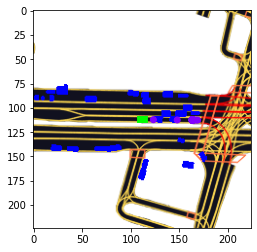

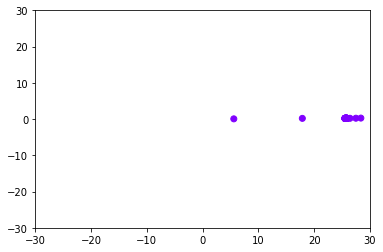

In [88]:
tr_it = iter(datamodule.train_dataloader())
progress_bar = tqdm(range(len(datamodule.train_dataloader())))
mhajam = mhajam.to(device)
for _ in progress_bar:
    try:
        data = next(tr_it)
    except StopIteration:
        tr_it = iter(train_dataloader)
        data = next(tr_it)

    mhajam.eval()
    
    agentsHist, lengths, rastImg, targetPos, targetValid, agentFromRaster = data
    agentsHist = agentsHist.to(device)
    rastImg = rastImg.to(device)
    targetPos = targetPos.to(device)
    targetValid = targetValid.to(device)
    agentFromRaster = agentFromRaster.to(device)
    
    # Forward pass
    aggPredRaster, probability, _ = mhajam((agentsHist, lengths, rastImg, targetPos, targetValid, agentFromRaster))
    rasterFromAgent = torch.inverse(agentFromRaster)[0]
    print(rasterFromAgent.shape, aggPredRaster.shape)
    predExt = torch.transpose(torch.cat((aggPredRaster[0].cpu(), torch.ones((16, 50, 1))), dim=-1), 1, 2)
    predRaster = torch.matmul(rasterFromAgent[None, : :], predExt)
    predRaster = torch.transpose(predRaster, 1, 2)[:, :, :2].detach().numpy()
    aggPredRaster = aggPredRaster.cpu().detach().numpy()
    aggTargets = targetPos.cpu().detach().numpy()
    print("agg targets shape: ", aggTargets.shape)

    import matplotlib

    colors = matplotlib.cm.rainbow(np.linspace(0, 1, 50))
    cs = [colors[i//50] for i in range(50)]
    print(cs)

    print(aggPredRaster.shape, probability.shape)

    print('target')
    # plt.scatter(aggTargets[0, :, 0], aggTargets[0, :, 1])
    # plt.xlim(-30, 30)
    # plt.ylim(-30, 30)
    # plt.show()
    im_ego = rasterizer.to_rgb(rastImg[0].detach().numpy().transpose(1, 2, 0))
    print(im_ego.shape)
    im_ego = np.swapaxes(im_ego, 0, 1)
    plt.imshow(im_ego)

    # plt.imshow(rastImg[0].sum(0).detach().numpy().swapaxes(0, 1))
    
    targetRaster = torch.transpose(torch.cat((targetPos[0].cpu(), torch.ones((50, 1))), dim=-1), 0, 1)
    targetRaster = torch.matmul(rasterFromAgent, targetRaster)
    print(targetRaster.shape)
    targetRaster = torch.transpose(targetRaster, 0, 1)[:, :1].detach().numpy()
    print(targetRaster.shape)

    plt.scatter(targetRaster, targetRaster, color=cs)
    plt.savefig(projectPath + '/trajectoryPlots/target.png')
    plt.show()
    # rastImg = rastImg[0].cpu().detach().numpy()

    for i in range(aggPredRaster.shape[1]):
        print('Head number', i)
        plt.imshow(im_ego)
        plt.scatter(predRaster[i, :, 0], predRaster[i, :, 1], color=cs)
        plt.savefig(projectPath + '/trajectoryPlots/head' + str(i) + '.png')
        plt.show()
        plt.scatter(aggPredRaster[0, i, :, 0], aggPredRaster[0, i, :, 1], color=cs)
        plt.xlim(-30, 30)
        plt.ylim(-30, 30)
        # print('preds', aggPredRaster[0, 0, :, :])
        # print('prob', probability[0, i])
        plt.show()
    # plt.imshow(rastImg.sum(axis=0))
    # plt.show()

    break

In [ ]:
# torch.save(mhajam.state_dict(), '/content/drive/MyDrive/College/S6/CS7643/FinalProject/mhajamFinal.pth')

In [ ]:
mhajam

MHAJAM(
  (lstmEnc): LSTM(32, 64, batch_first=True)
  (rasterCNN): Sequential(
    (0): Conv2d(25, 64, kernel_size=(7, 7), stride=(2, 2), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequenti

# Training

note: if you're on MacOS and using `py_satellite` rasterizer, you may need to disable opencv multiprocessing by adding:
`cv2.setNumThreads(0)` before the following cell. This seems to only affect running in python notebook and it's caused by the `cv2.warpaffine` function

In [ ]:
# ==== TRAIN LOOP
tr_it = iter(train_dataloader)
progress_bar = tqdm(range(cfg["train_params"]["max_num_steps"]))
losses_train = []
for _ in progress_bar:
    try:
        data = next(tr_it)
    except StopIteration:
        tr_it = iter(train_dataloader)
        data = next(tr_it)
    model.train()
    torch.set_grad_enabled(True)
    loss, _ = forward(data, model, device, criterion)

    # Backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses_train.append(loss.item())
    progress_bar.set_description(f"loss: {loss.item()} loss(avg): {np.mean(losses_train)}")

loss: 0.35441944003105164 loss(avg): 6.989409580826759: 100%|██████████| 5/5 [00:10<00:00,  2.03s/it]


### Plot Loss Curve
We can plot the train loss against the iterations (batch-wise)

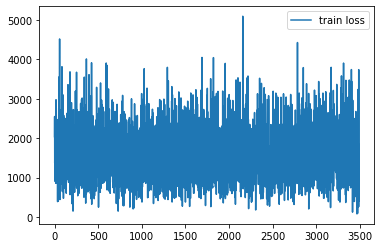

In [ ]:
plt.plot(np.arange(len(losses_train)), losses_train, label="train loss")
plt.legend()
plt.show()

# Evaluation

Evaluation follows a slightly different protocol than training. When working with time series, we must be absolutely sure to avoid leaking the future in the data.

If we followed the same protocol of training, one could just read ahead in the `.zarr` and forge a perfect solution at run-time, even for a private test set.

As such, **the private test set for the competition has been "chopped" using the `chop_dataset` function**.

In [ ]:
# ===== GENERATE AND LOAD CHOPPED DATASET
num_frames_to_chop = 100
eval_cfg = cfg["val_dataloader"]
eval_base_path = create_chopped_dataset(dm.require(eval_cfg["key"]), cfg["raster_params"]["filter_agents_threshold"], 
                              num_frames_to_chop, cfg["model_params"]["future_num_frames"], MIN_FUTURE_STEPS)

/usr/local/lib/python3.6/dist-packages/l5kit/data/zarr_utils.py:243: RuntimeWarning: zarr dataset path doesn't exist. Open will fail for this dataset!
  output_dataset = ChunkedDataset(output_zarr)
copying: 100%|██████████| 100/100 [00:01<00:00, 51.39it/s]
/usr/local/lib/python3.6/dist-packages/l5kit/evaluation/extract_ground_truth.py:59: RuntimeWarning: you're running with a custom agents_mask
  dataset = AgentDataset(cfg=cfg, zarr_dataset=zarr_dataset, rasterizer=rasterizer, agents_mask=agents_mask)
extracting GT: 100%|██████████| 480/480 [00:06<00:00, 75.41it/s]


The result is that **each scene has been reduced to only 100 frames**, and **only valid agents in the 100th frame will be used to compute the metrics**. Because following frames in the scene have been chopped off, we can't just look ahead to get the future of those agents.

In this example, we simulate this pipeline by running `chop_dataset` on the validation set. The function stores:
- a new chopped `.zarr` dataset, in which each scene has only the first 100 frames;
- a numpy mask array where only valid agents in the 100th frame are True;
- a ground-truth file with the future coordinates of those agents;

Please note how the total number of frames is now equal to the number of scenes multipled by `num_frames_to_chop`. 

The remaining frames in the scene have been sucessfully chopped off from the data

In [ ]:
eval_zarr_path = str(Path(eval_base_path) / Path(dm.require(eval_cfg["key"])).name)
eval_mask_path = str(Path(eval_base_path) / "mask.npz")
eval_gt_path = str(Path(eval_base_path) / "gt.csv")

eval_zarr = ChunkedDataset(eval_zarr_path).open()
eval_mask = np.load(eval_mask_path)["arr_0"]
# ===== INIT DATASET AND LOAD MASK
eval_dataset = AgentDataset(cfg, eval_zarr, rasterizer, agents_mask=eval_mask)
eval_dataloader = DataLoader(eval_dataset, shuffle=eval_cfg["shuffle"], batch_size=eval_cfg["batch_size"], 
                             num_workers=eval_cfg["num_workers"])
print(eval_dataset)

+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
| Num Scenes | Num Frames | Num Agents | Num TR lights | Total Time (hr) | Avg Frames per Scene | Avg Agents per Frame | Avg Scene Time (sec) | Avg Frame frequency |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
|    100     |   10000    |   751440   |     130740    |       0.28      |        100.00        |        75.14         |        10.00         |        10.00        |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: you're running with a custom agents_mask
  


### Storing Predictions
There is a small catch to be aware of when saving the model predictions. The output of the models are coordinates in `agent` space and we need to convert them into displacements in `world` space.

To do so, we first convert them back into the `world` space and we then subtract the centroid coordinates.

In [ ]:
# ==== EVAL LOOP
model.eval()
torch.set_grad_enabled(False)
criterion = custom_neg_multi_log_likelihood
# store information for evaluation
future_coords_offsets_pd = []
timestamps = []
agent_ids = []

progress_bar = tqdm(eval_dataloader)
for data in progress_bar:
    _, ouputs = forward(data, model, device, criterion)
    
    # convert agent coordinates into world offsets
    agents_coords = ouputs.cpu().numpy()
    world_from_agents = data["world_from_agent"].numpy()
    centroids = data["centroid"].numpy()
    coords_offset = []
    
    for agent_coords, world_from_agent, centroid in zip(agents_coords, world_from_agents, centroids):
        coords_offset.append(transform_points(agent_coords, world_from_agent) - centroid[:2])
    
    future_coords_offsets_pd.append(np.stack(coords_offset))
    timestamps.append(data["timestamp"].numpy().copy())
    agent_ids.append(data["track_id"].numpy().copy())
    



  0%|          | 0/40 [00:00<?, ?it/s]

ValueError: ignored

### Save results
After the model has predicted trajectories for our evaluation set, we can save them in a `csv` file.

During the competition, only the `.zarr` and the mask will be provided for the private test set evaluation.
Your solution is expected to generate a csv file which will be compared to the ground truth one on a separate server

In [ ]:
pred_path = f"{gettempdir()}/pred.csv"

write_pred_csv(pred_path,
               timestamps=np.concatenate(timestamps),
               track_ids=np.concatenate(agent_ids),
               coords=np.concatenate(future_coords_offsets_pd),
              )

In [ ]:
print(pred_path)

### Perform Evaluation
Pleae note that our metric supports multi-modal predictions (i.e. multiple predictions for a single GT trajectory). In that case, you will need to provide a confidence for each prediction (confidences must all be between 0 and 1 and sum to 1).

In this simple example we don't generate multiple trajectories, so we won't pass any confidences vector. Internally, the metric computation will assume a single trajectory with confidence equal to 1

In [ ]:
metrics = compute_metrics_csv(eval_gt_path, pred_path, [neg_multi_log_likelihood, time_displace])
for metric_name, metric_mean in metrics.items():
    print(metric_name, metric_mean)


### Visualise Results
We can also visualise some results from the ego (AV) point of view for those frames of interest (the 100th of each scene).

However, as we chopped off the future from the dataset **we must use the GT csv if we want to plot the future trajectories of the agents**


(25, 224, 224)


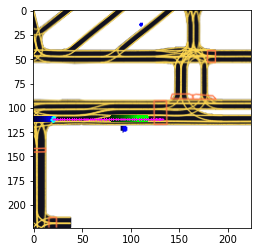

In [ ]:
model.eval()
torch.set_grad_enabled(False)

# build a dict to retrieve future trajectories from GT
gt_rows = {}
for row in read_gt_csv(eval_gt_path):
    gt_rows[row["track_id"] + row["timestamp"]] = row["coord"]

eval_ego_dataset = EgoDataset(cfg, eval_dataset.dataset, rasterizer)

for frame_number in range(99, len(eval_zarr.frames), 100):  # start from last frame of scene_0 and increase by 100
    agent_indices = eval_dataset.get_frame_indices(frame_number) 
    if not len(agent_indices):
        continue

    # get AV point-of-view frame
    data_ego = eval_ego_dataset[frame_number]
    print(data_ego['image'].shape)
    im_ego = rasterizer.to_rgb(data_ego["image"].transpose(1, 2, 0))
    center = np.asarray(cfg["raster_params"]["ego_center"]) * cfg["raster_params"]["raster_size"]
    
    predicted_positions = []
    target_positions = []

    for v_index in agent_indices:
        data_agent = eval_dataset[v_index]

        out_net = model(torch.from_numpy(data_agent["image"]).unsqueeze(0).to(device))
        out_pos = out_net[0].reshape(-1, 2).detach().cpu().numpy()
        # store absolute world coordinates
        predicted_positions.append(transform_points(out_pos, data_agent["world_from_agent"]))
        # retrieve target positions from the GT and store as absolute coordinates
        track_id, timestamp = data_agent["track_id"], data_agent["timestamp"]
        target_positions.append(gt_rows[str(track_id) + str(timestamp)] + data_agent["centroid"][:2])


    # convert coordinates to AV point-of-view so we can draw them
    predicted_positions = transform_points(np.concatenate(predicted_positions), data_ego["raster_from_world"])
    target_positions = transform_points(np.concatenate(target_positions), data_ego["raster_from_world"])

    draw_trajectory(im_ego, predicted_positions, PREDICTED_POINTS_COLOR)
    draw_trajectory(im_ego, target_positions, TARGET_POINTS_COLOR)

    plt.imshow(im_ego[::-1])
    plt.show()